# Time SU2 runs depending on mesh size
In this example we do the following:
1. Get coordinates of a geometry.
1. Repeat for several mesh sizes.
   1. Mesh it using Gmsh and save it in the SU2 mesh format.
   1. Then use a SU2 configuration file and compute CL and CD for the airfoil.

## Some Basic Imports

In [1]:
import time
import subprocess
import os
import csv

import numpy as np
import matplotlib.pyplot as plt

from mesh_func import mesh_func

## Get Geometry - Mesh it
We do the following:
1. Start with a 2D geometry defined by an ordered set of points on the curve. Assume it is a simple
    curve.
1. Use Gmsh to mesh the geometry. Define appropriate physical groups.
1. Export to SU2 format as that is what SU2 can work with.

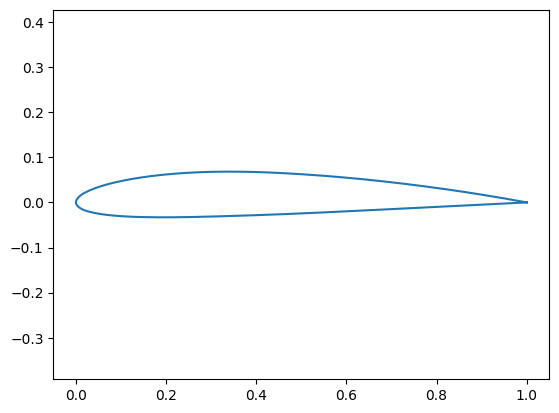

In [2]:
# Sample points on the curve that you want to mesh
X = np.loadtxt('naca2410.dat')

plt.plot(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

## Run SU2 for Different Mesh Sizes

In [3]:
mesh_size_list = [(0.5, 10.0), (0.5, 5.0), (0.1, 5.0), (0.01, 5.0), (0.01, 2.5), (0.005, 2.5),
                  (0.005, 2.0), (0.005, 1.0), (0.001, 1.0)]

In [4]:
for i in range(len(mesh_size_list)):
    start_time = time.time()


    # Set mesh parameters
    mesh_size_at_airfoil = mesh_size_list[i][0]
    mesh_size_at_farfield = mesh_size_list[i][1]
    farfield_factor = 100
    mesh_file_location = 'airfoil_mesh.su2'

    mesh_details, physical_groups = mesh_func(X,
                        mesh_size_at_airfoil = mesh_size_at_airfoil,
                        mesh_size_at_farfield = mesh_size_at_farfield,
                        farfield_factor = farfield_factor,
                        model_name = 'airfoil',
                        mesh_file_location = mesh_file_location,
                        visualize = False
                        )
    num_nodes = mesh_details['num_nodes']
    num_elements = mesh_details['num_elements']


    # Run SU2
    cfg_file_path = 'su2_EULER.cfg'
    with open(os.devnull, 'w') as devnull:
        subprocess.run(['SU2_CFD', cfg_file_path], check = True, stdout = devnull,
                       stderr = subprocess.STDOUT)

    end_time = time.time()
    total_time = end_time - start_time


    # Read last line from history.csv
    output_data_file_path = 'history.csv'
    with open(output_data_file_path, 'r') as f:
        rows = list(csv.DictReader(f))
        last_row = rows[-1]

        output_dict = {}
        for key, values in last_row.items():
            if key == 'Inner_Iter':
                output_dict[key] = float(values.strip())
                continue
            output_dict[key.strip()[1:-1]] = float(values.strip())
        
        CL = output_dict['CL']
        CD = output_dict['CD']
        iter = int(output_dict['Inner_Iter'])
    

    print(f'Num Elements: {num_elements:{7}}, Time: {total_time:10.6f}, CL: {CL:8.6f}, CD: {CD:8.6f}, Iter: {iter:{4}}')


    # Delete files created by SU2
    os.remove('history.csv')
    os.remove('flow.vtu')
    os.remove('surface_flow.csv')
    os.remove('restart_flow.dat')

Num Elements:    5022, Time:   6.371407, CL: 0.223444, CD: 0.003188, Iter:  501
Num Elements:   15728, Time:  22.286196, CL: 0.201139, CD: -0.002471, Iter:  447
Num Elements:   15728, Time:  22.477652, CL: 0.201139, CD: -0.002471, Iter:  447
Num Elements:   18082, Time:  30.396392, CL: 0.183497, CD: 0.000064, Iter:  510
Num Elements:   54290, Time: 145.481451, CL: 0.249176, CD: -0.002233, Iter:  617
Num Elements:   59160, Time: 147.510091, CL: 0.302505, CD: -0.002810, Iter:  739
Num Elements:   85862, Time: 260.004140, CL: 0.245746, CD: -0.001180, Iter:  663
Num Elements:  301402, Time: 1169.207379, CL: 0.209826, CD: -0.002518, Iter:  769
Num Elements:  417050, Time: 3351.727946, CL: 0.266783, CD: -0.000346, Iter: 1525
